## Rank sum test

In [1]:
''' Dependencies '''
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import warnings
import pandas as pd
import numpy as np
import scipy
import sys
import statsmodels.api as sm
from tqdm import tqdm as pbar

# my scripts
from pyaldata import * 
import preprocess
from utils import *

# Plotting
from IPython.display import display, set_matplotlib_formats, HTML
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns

cs = ['#43D789', '#801607', '#8DB8ED', '#94B0B6', '#e42c12', '#005CA8', '#127340', '#111851'] # Line colors
cmap = matplotlib.colors.ListedColormap(['#ff9c8d', '#dafce3']) # Color for False and True

sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('ticks', rc={ 'figure.facecolor': 'none', 'axes.facecolor':'none'})
sns.set_context('notebook', rc={'lines.linewidth':1.5})

%config InlineBackend.figure_format = 'retina'

/Users/Daphne/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
''' Load dictionaries '''

main_dict = np.load('/Users/Daphne/Data/main_dict.npy', allow_pickle='TRUE').item()
#surr_dict = np.load('/Users/Daphne/Data/surr_dict_20.npy', allow_pickle='TRUE').item()
THRESHOLDS_VARE = np.round(np.arange(0.2, 0.95, 0.025), 3)

evar_to_pcs = []
for s in main_dict.keys():
    evar_to_pcs.append([np.argmax(main_dict[s]['model'].explained_variance_ratio_.cumsum() > THRESHOLDS_VARE[i]) for i in range(len(THRESHOLDS_VARE))])

    ''' Experimental sessions and electrode maps '''
m1_emap  = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left M1 SN 6250-001474.cmp'),  elecs=range(1,97))
pmd_emap = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left PMd SN 6251-001469.cmp'), elecs=range(1,97))

In [3]:
''' Parameters '''

MONKEY_C = 8
MONKEY_M = 7
OTHER_ARRAY_D = 50
total_n_sessions = [main_dict[s]['pcs'].shape[0] for s in main_dict.keys()]
# dims_normalized = [evar_to_pcs[i, :] / total_n_sessions[i] for i in range(len(total_n_sessions))]
DIM_RANGE = [5, 10, 15, 20] # by manifold dim
varexp = ['0.3', '0.4', '0.45', '0.525'] # For surrogates

### Non parametric rank sum test

In [4]:
# D = '5'
# s = '2016-09-09'
# vare = '0.475'

# # Choose dim by dims
# df_dist_surr = surr_dict['1']['vare'][vare]['distances_df']
# df_dist_actual = main_dict[s]['dim'][D]['distances_df']

# df_both = pd.concat([df_dist_surr, df_dist_actual])

### Look at one session across 3 dimensions (5, 10, 15)

In [5]:
# df_both_Ds = []

# for i in range(len(DIM_RANGE)):
    
#     D = str(DIM_RANGE[i])
#     V = varexp[i]
    
#     # Choose dim by dims
#     df_dist_surr = surr_dict['1']['vare'][V]['distances_df']
#     df_dist_actual = main_dict['2016-09-09']['dim'][D]['distances_df']
    
#     df_both = pd.concat([df_dist_surr, df_dist_actual])
    
#     df_both_Ds.append(df_both)

In [6]:
''' Figure settings '''
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('ticks', rc={ 'figure.facecolor': 'none', 'axes.facecolor':'none'})
sns.set_context('notebook', rc={'lines.linewidth':1.5})

In [9]:
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['lightgray', 'b'])

# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# axs[0].set_title(r'Monkey C single session $\mid D = 5$' , loc='left')
# sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=df_both_Ds[0], hue='Type', split=True, saturation=0.7, ax=axs[0]);
# axs[0].set_ylabel(r'$\rho$')
# axs[0].set_xlabel('')
# axs[0].set_xticklabels(['same electrode', 'same region', 'other region'])

# axs[1].set_title(r'$D = 10$' , loc='left')
# sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=df_both_Ds[1], hue='Type', split=True, saturation=0.7, ax=axs[1]);
# axs[1].set_ylabel('')
# axs[1].set_xlabel('')
# axs[1].set_xticklabels(['same electrode', 'same region', 'other region'])

# axs[2].set_title(r'$D = 15$' , loc='left')
# sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=df_both_Ds[2], hue='Type', split=True, saturation=0.7, ax=axs[2]);
# axs[2].set_ylabel('')
# axs[2].set_xlabel('')
# axs[2].set_xticklabels(['same electrode', 'same region', 'other region'])

# axs[0].legend(loc='upper right')
# axs[1].legend(loc='upper right')
# axs[2].legend(loc='upper right')

# sns.despine()

### Pool data across sessions

In [14]:
''' MONKEY C '''

D_all_df_both = []

for i in range(len(DIM_RANGE)):

    D = str(DIM_RANGE[i])
    V = varexp[i]
    
    # Actual
    df_across_actual = main_dict['2016-09-09']['dim'][D]['distances_df'] # initialize

    for i, s in enumerate(list(main_dict.keys())[:MONKEY_C]): # for all monkey C sessions
        if i == 0: pass
        df_across_actual.append(main_dict[s]['dim'][D]['distances_df'])

    # Surrogates
    df_across_surr = surr_dict['2']['vare'][V]['distances_df']

    for i, s in enumerate(list(surr_dict.keys())[:MONKEY_C]):
        if i == 0: pass
        df_across_surr.append(surr_dict[s]['vare'][V]['distances_df'])
        
    # concatenate
    df_both_across = pd.concat([df_across_surr, df_across_actual])
    D_all_df_both.append(df_both_across)

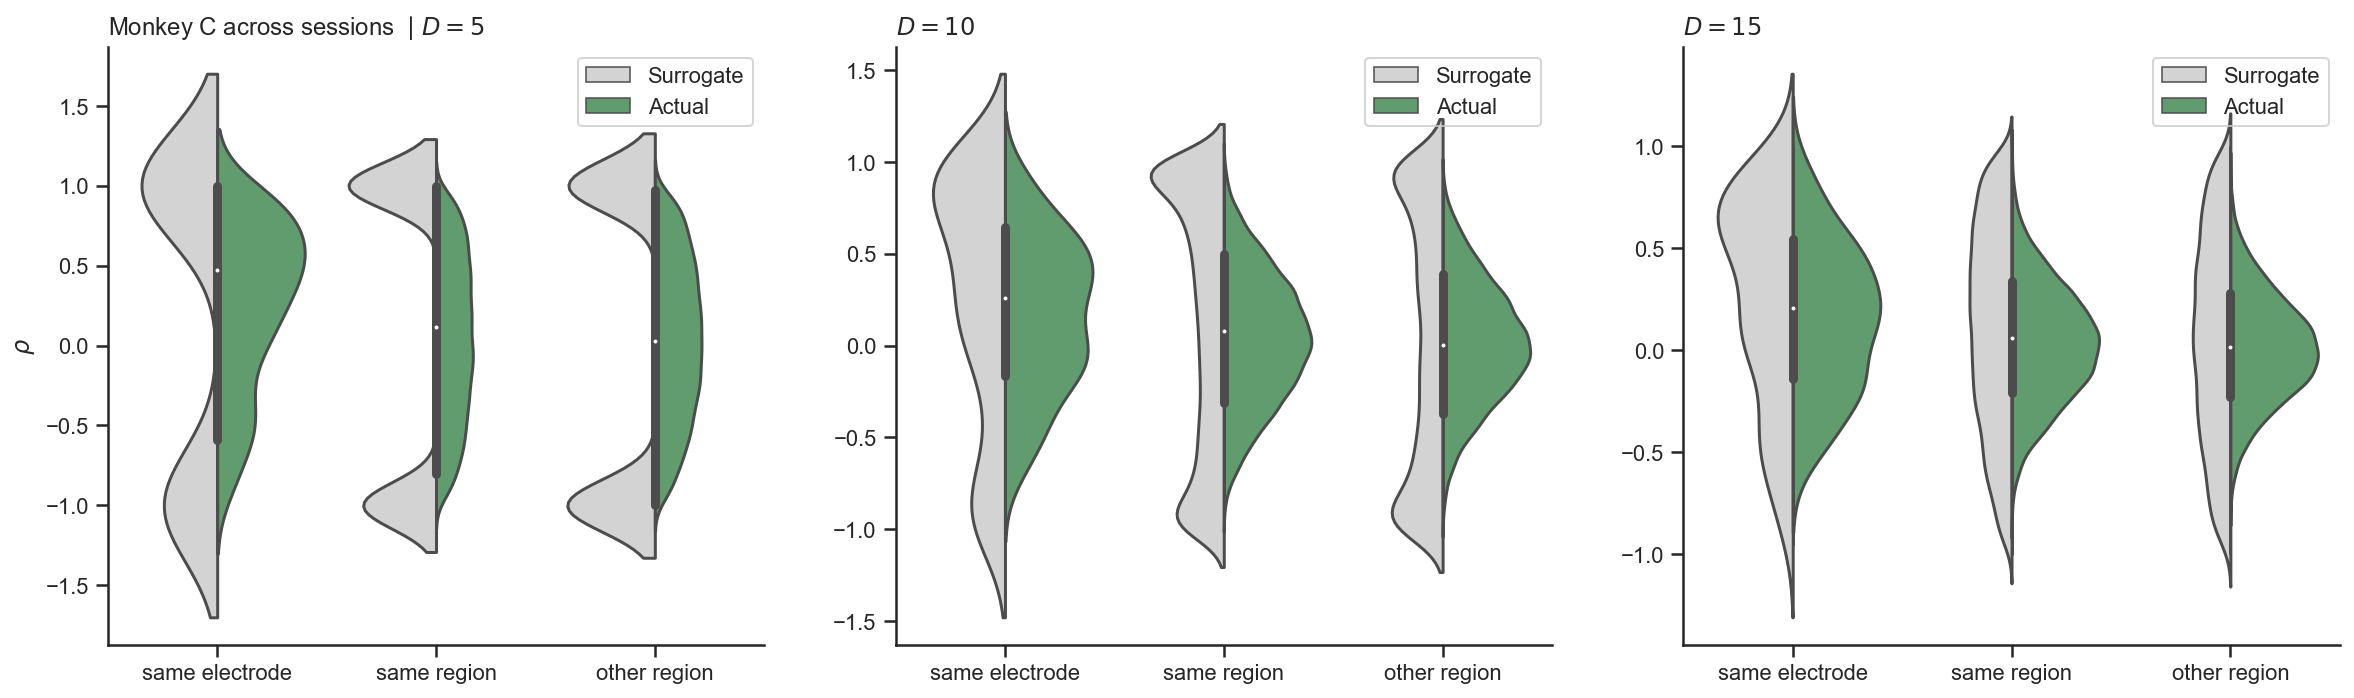

In [30]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['lightgray', 'g'])

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5.5))

axs[0].set_title(r'Monkey C across sessions $\mid D = 5$' , loc='left')
sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=D_all_df_both[0], hue='Type', split=True, saturation=0.7, ax=axs[0]);
axs[0].set_ylabel(r'$\rho$')
axs[0].set_xlabel('')
axs[0].set_xticklabels(['same electrode', 'same region', 'other region'])

axs[1].set_title(r'$D = 10$' , loc='left')
sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=D_all_df_both[1], hue='Type', split=True, saturation=0.7, ax=axs[1]);
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].set_xticklabels(['same electrode', 'same region', 'other region'])

axs[2].set_title(r'$D = 15$' , loc='left')
sns.violinplot(y='correlation', x='category', order=['same electrode', 'same array', 'other array'], data=D_all_df_both[2], hue='Type', split=True, saturation=0.7, ax=axs[2]);
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].set_xticklabels(['same electrode', 'same region', 'other region'])

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
axs[2].legend(loc='upper right')
sns.despine()

In [17]:
# sns.kdeplot(rhos_SE_all, alpha=0.2, label='same electrode', shade=True)
# sns.kdeplot(rhos_SA_all, alpha=0.2, label='same region', shade=True)
# sns.kdeplot(rhos_OA_all, alpha=0.2, label='other region', shade=True)

# plt.title('Correlation distributions normalized by # obervations within groups | Monkey C' )
# plt.legend(fontsize=13, loc=2)
# plt.xlabel(r'$\rho$')
# sns.despine()

In [18]:
df_D5 = df_both_Ds[0] # select df

SE_D5 = df_D5.loc[(df_D5['Type'] == 'Actual') & (df_D5['category'] == 'same electrode')]['correlation'].values
SA_D5 = df_D5.loc[(df_D5['Type'] == 'Actual') & (df_D5['category'] == 'same array')]['correlation'].values
OA_D5 = df_D5.loc[(df_D5['Type'] == 'Actual') & (df_D5['category'] == 'other array')]['correlation'].values

In [18]:
#scipy.stats.ranksums(SE_D5, SA_D5, alternative='two-sided').values

In [20]:
scipy.stats.ranksums(SA_D5, OA_D5, 'two-sided')

RanksumsResult(statistic=1.0951592707382594, pvalue=0.27344686576062993)

In [21]:
scipy.stats.ranksums(SE_D5, OA_D5, 'two-sided')

RanksumsResult(statistic=5.9368581794780075, pvalue=2.905357765489091e-09)

### Less than

In [22]:
scipy.stats.ranksums(SE_D5, SA_D5, 'less')

RanksumsResult(statistic=5.655325078546309, pvalue=0.9999999922224211)

In [23]:
scipy.stats.ranksums(SE_D5, OA_D5, 'less')

RanksumsResult(statistic=5.9368581794780075, pvalue=0.9999999985473211)

In [24]:
scipy.stats.ranksums(SA_D5, OA_D5, 'less')

RanksumsResult(statistic=1.0951592707382594, pvalue=0.863276567119685)

### Greater than

In [25]:
scipy.stats.ranksums(SE_D5, SA_D5, 'greater')

RanksumsResult(statistic=5.655325078546309, pvalue=7.777578901775719e-09)

In [26]:
scipy.stats.ranksums(SE_D5, OA_D5, 'greater')

RanksumsResult(statistic=5.9368581794780075, pvalue=1.4526788827445455e-09)

In [27]:
scipy.stats.ranksums(SA_D5, OA_D5, 'greater')

RanksumsResult(statistic=1.0951592707382594, pvalue=0.13672343288031497)

## Make grid for both monkeys

In [5]:
''' Parameters '''

S = 15 # Number of sessions
L = 30 # Datapoints (vare)
ALPHA = 0.01 # Set significance level

cmap = matplotlib.colors.ListedColormap(['lightgray', 'b', 'g']) # Color for False and True'

In [6]:
''' Run rank sum test across fraction of var explained '''

sessions_twoSided_SE_SR = []
sessions_twoSided_SE_OR = []
sessions_twoSided_SR_OR = []

sessions_lt_SE_SR = []
sessions_lt_SE_OR = []
sessions_lt_SR_OR = []

sessions_gt_SE_SR = []
sessions_gt_SE_OR = []
sessions_gt_SR_OR = []

for s in main_dict.keys(): # for each session
        
    for v in main_dict[s]['vare'].keys(): # for each threshold of variance explained
        
        df = main_dict[s]['vare'][v]['distances_df'] # get df for that level of exp var
        
        # Get 3 distributions
        corrs_SE = df.loc[df['category'] == 'same electrode']['correlation'].values
        corrs_SR = df.loc[df['category'] == 'same array']['correlation'].values
        corrs_OR = df.loc[df['category'] == 'other array']['correlation'].values
        
        # get lists of tuples (30 x 15) = (test statistic, pval)
        sessions_twoSided_SE_SR.append(scipy.stats.ranksums(corrs_SE, corrs_SR, alternative='two-sided') * 1)
        sessions_twoSided_SE_OR.append(scipy.stats.ranksums(corrs_SE, corrs_OR, alternative='two-sided') * 1)
        sessions_twoSided_SR_OR.append(scipy.stats.ranksums(corrs_SR, corrs_OR, alternative='two-sided') * 1)
        
        # LESS THAN
        sessions_lt_SE_SR.append(scipy.stats.ranksums(corrs_SE, corrs_SR, alternative='less') * 1)
        sessions_lt_SE_OR.append(scipy.stats.ranksums(corrs_SE, corrs_OR, alternative='less') * 1)
        sessions_lt_SR_OR.append(scipy.stats.ranksums(corrs_SR, corrs_OR, alternative='less') * 1)
        
        # LESS THAN
        sessions_gt_SE_SR.append(scipy.stats.ranksums(corrs_SE, corrs_SR, alternative='greater') * 1)
        sessions_gt_SE_OR.append(scipy.stats.ranksums(corrs_SE, corrs_OR, alternative='greater') * 1)
        sessions_gt_SR_OR.append(scipy.stats.ranksums(corrs_SR, corrs_OR, alternative='greater') * 1)

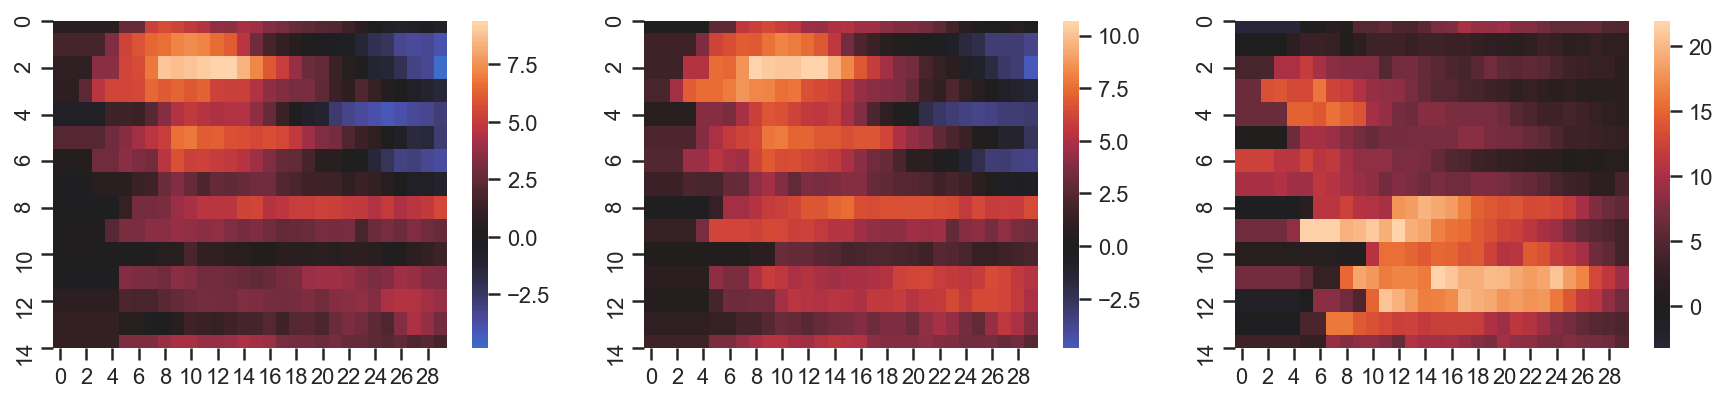

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))

sns.heatmap(np.array([i[0] for i in sessions_twoSided_SE_SR]).reshape(15, 30), center=0, ax=axs[0])

sns.heatmap(np.array([i[0] for i in sessions_twoSided_SE_OR]).reshape(15, 30), center=0, ax=axs[1])

sns.heatmap(np.array([i[0] for i in sessions_twoSided_SR_OR]).reshape(15, 30), center=0, ax=axs[2]);

In [8]:
# Two sided
Tvals_ts_SE_SR = np.array([i[0] for i in sessions_twoSided_SE_SR]).reshape(S, L)
Pvals_ts_SE_SR = np.array([i[1] for i in sessions_twoSided_SE_SR]).reshape(S, L)

Tvals_ts_SE_OR = np.array([i[0] for i in sessions_twoSided_SE_OR]).reshape(S, L)
Pvals_ts_SE_OR = np.array([i[1] for i in sessions_twoSided_SE_OR]).reshape(S, L)

Tvals_ts_SR_OR = np.array([i[0] for i in sessions_twoSided_SR_OR]).reshape(S, L)
Pvals_ts_SR_OR = np.array([i[1] for i in sessions_twoSided_SR_OR]).reshape(S, L)

# Less than 
Tvals_lt_SE_SR = np.array([i[0] for i in sessions_lt_SE_SR]).reshape(S, L)
Pvals_lt_SE_SR = np.array([i[1] for i in sessions_lt_SE_SR]).reshape(S, L)

Tvals_lt_SE_OR = np.array([i[0] for i in sessions_lt_SE_OR]).reshape(S, L)
Pvals_lt_SE_OR = np.array([i[1] for i in sessions_lt_SE_OR]).reshape(S, L)

Tvals_lt_SR_OR = np.array([i[0] for i in sessions_lt_SR_OR]).reshape(S, L)
Pvals_lt_SR_OR = np.array([i[1] for i in sessions_lt_SR_OR]).reshape(S, L)

# Greater than 
Tvals_gt_SE_SR = np.array([i[0] for i in sessions_gt_SE_SR]).reshape(S, L)
Pvals_gt_SE_SR = np.array([i[1] for i in sessions_gt_SE_SR]).reshape(S, L)

Tvals_gt_SE_OR = np.array([i[0] for i in sessions_gt_SE_OR]).reshape(S, L)
Pvals_gt_SE_OR = np.array([i[1] for i in sessions_gt_SE_OR]).reshape(S, L)

Tvals_gt_SR_OR = np.array([i[0] for i in sessions_gt_SR_OR]).reshape(S, L)
Pvals_gt_SR_OR = np.array([i[1] for i in sessions_gt_SR_OR]).reshape(S, L)

In [9]:
def filter_it(Pvals, Tvals, ALPHA=0.01):
    # Set all non significant entries to 0
    Pvals[np.where(Pvals > ALPHA)] = 0
    # Set all significant entries where t < 0 to 1 and for t > 0 to 2
    Pvals[np.where(np.logical_and(Tvals < 0, Pvals != 0))] = 1
    Pvals[np.where(np.logical_and(Tvals >= 0, Pvals != 0))] = 2
    
    return Pvals

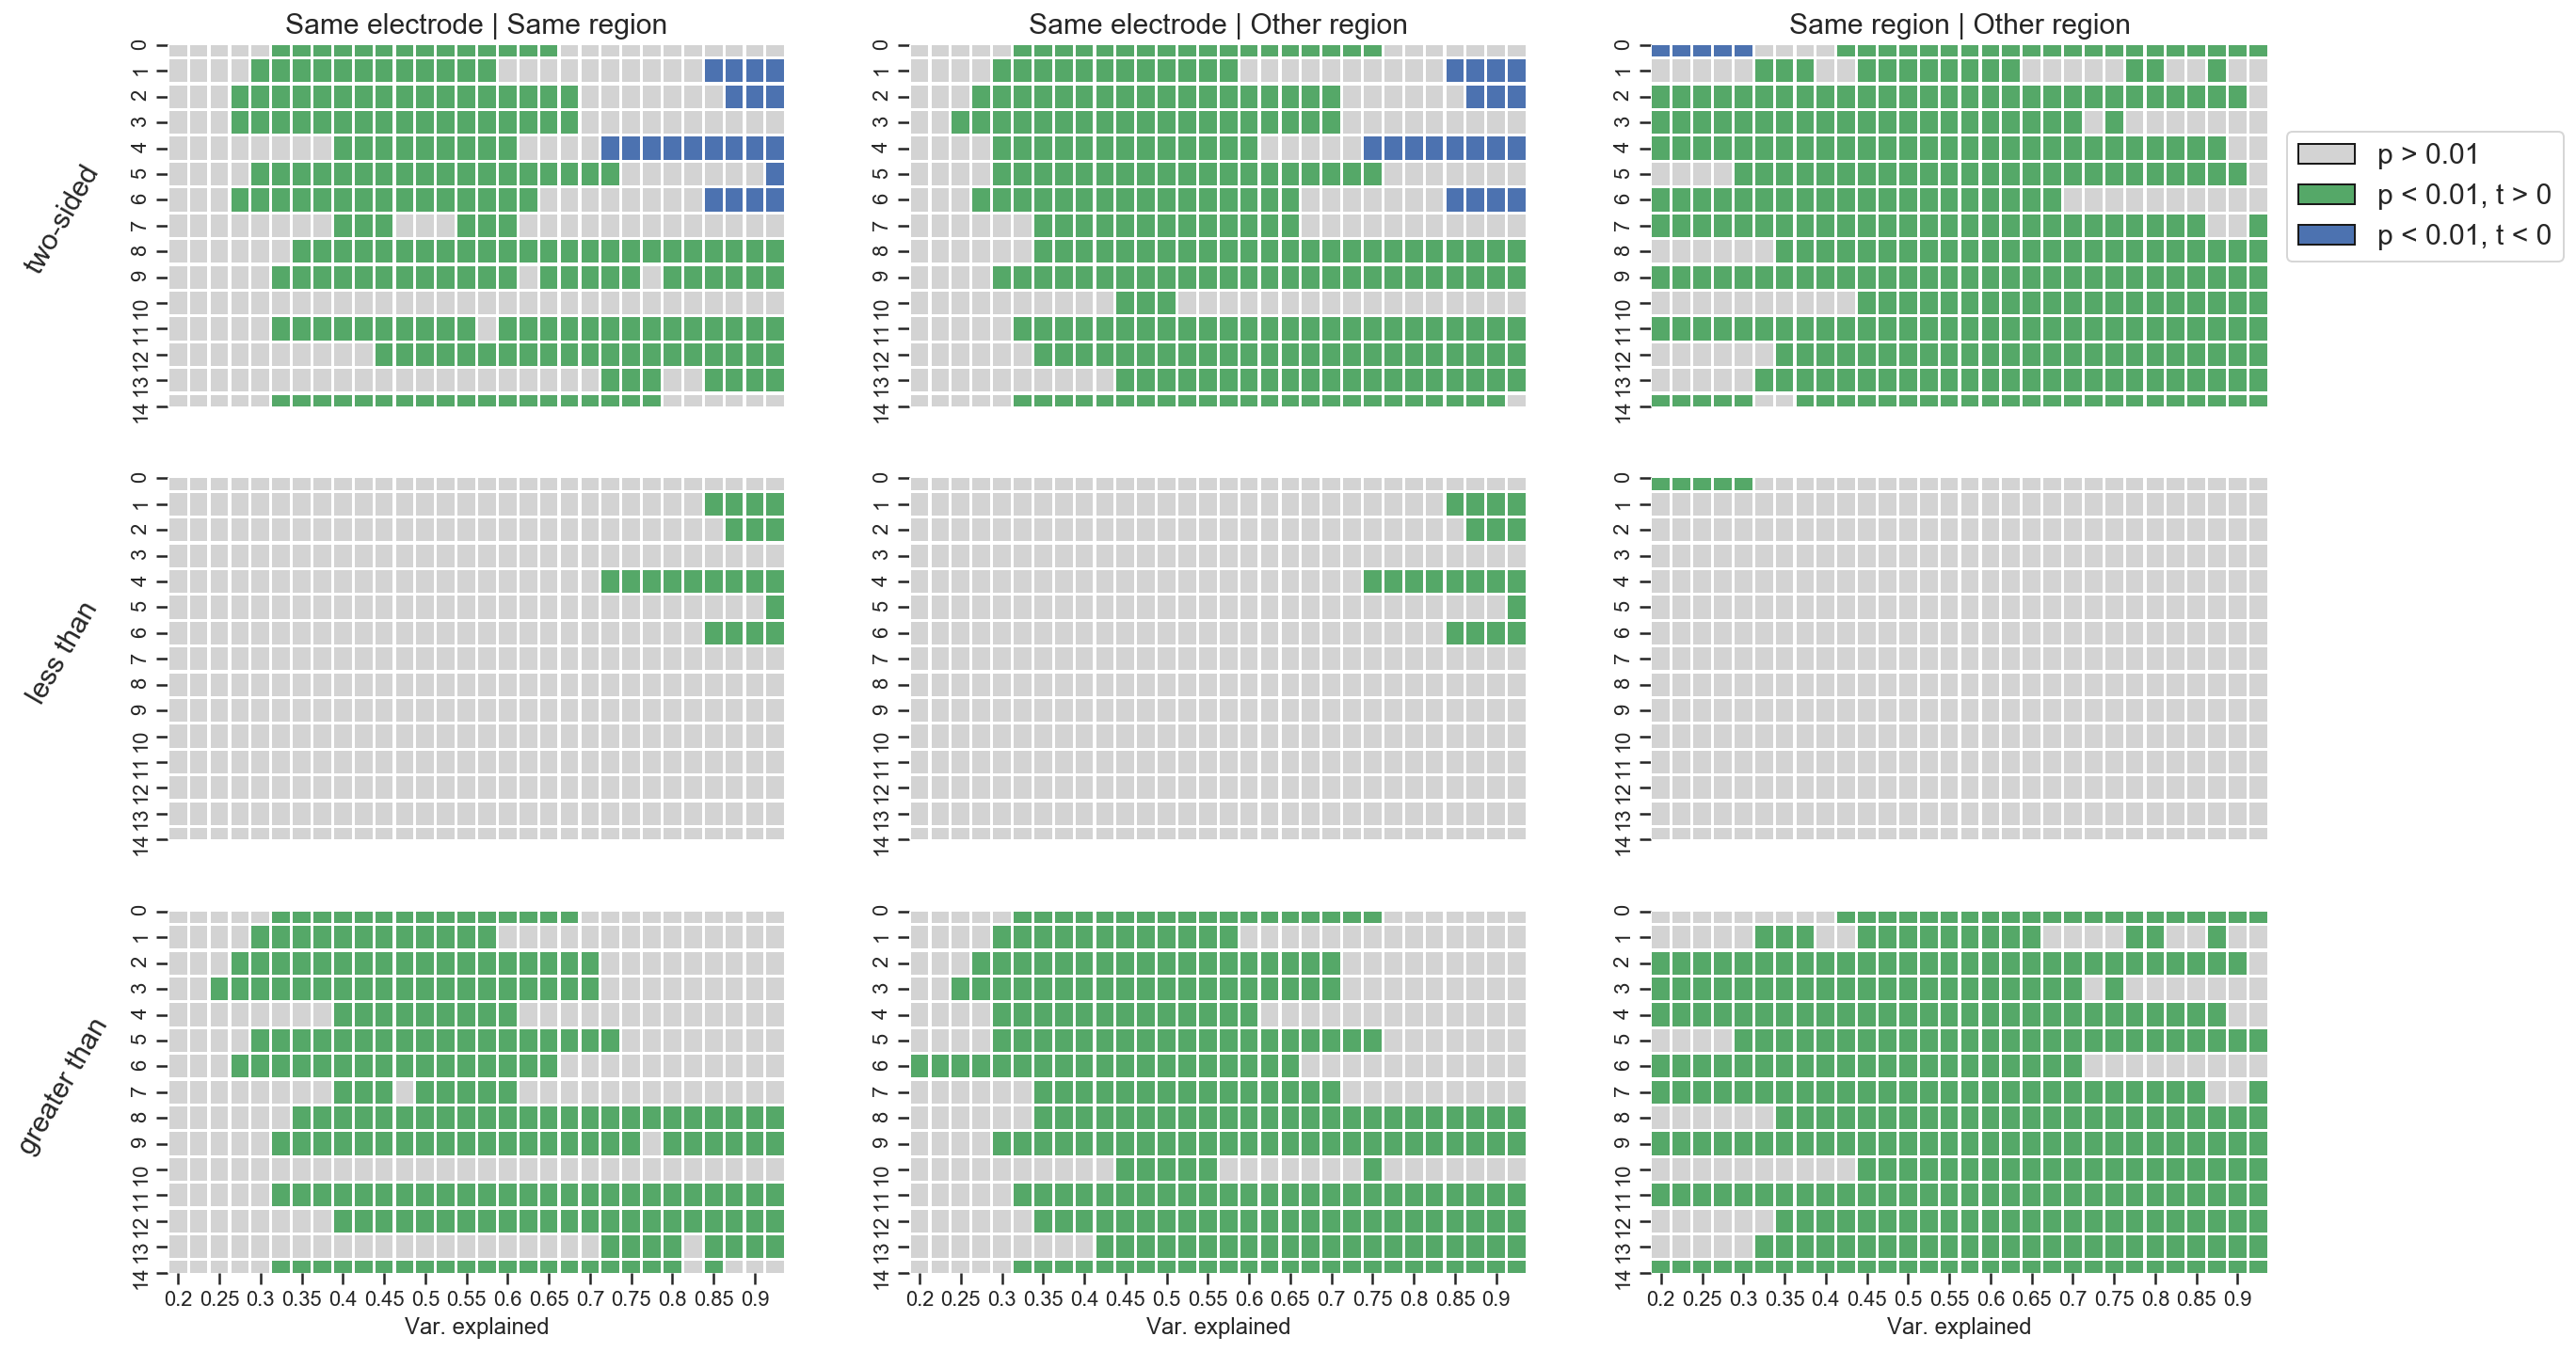

In [10]:
cmap = matplotlib.colors.ListedColormap(['lightgray', 'b', 'g']) # Color for False and True'

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))

axs[0, 0].set_title('Same electrode | Same region', fontsize=15)
axs[0, 1].set_title('Same electrode | Other region', fontsize=15)
axs[0, 2].set_title('Same region | Other region', fontsize=15)

# Make heatmaps for pvalues two sided tests
sns.heatmap(filter_it(Pvals_ts_SE_SR, Tvals_ts_SE_SR), linewidth=1.1, xticklabels=False, cmap=cmap, cbar=False, ax=axs[0, 0])

sns.heatmap(filter_it(Pvals_ts_SE_OR, Tvals_ts_SE_OR), linewidth=1.1, xticklabels=False, cmap=cmap, cbar=False, ax=axs[0, 1])

sns.heatmap(filter_it(Pvals_ts_SR_OR, Tvals_ts_SR_OR), linewidth=1.1, xticklabels=False, cmap=cmap, cbar=False, ax=axs[0, 2])

# Make heatmaps for pvalues LESS 
sns.heatmap(filter_it(Pvals_lt_SE_SR, Tvals_lt_SE_SR), linewidth=1.1, xticklabels=False, cmap=cmap, cbar=False, ax=axs[1, 0])

sns.heatmap(filter_it(Pvals_lt_SE_OR, Tvals_lt_SE_OR), linewidth=1.1, xticklabels=False, cmap=cmap, cbar=False, ax=axs[1, 1])

sns.heatmap(filter_it(Pvals_lt_SR_OR, Tvals_lt_SR_OR), linewidth=1.1, xticklabels=False, cmap=cmap, cbar=False, ax=axs[1, 2])

# Make heatmaps for pvalues GREATER 
sns.heatmap(filter_it(Pvals_gt_SE_SR, Tvals_gt_SE_SR), linewidth=1.1, cmap=cmap, cbar=False, ax=axs[2, 0])

sns.heatmap(filter_it(Pvals_gt_SE_OR, Tvals_gt_SE_OR), linewidth=1.1, cmap=cmap, cbar=False, ax=axs[2, 1])

sns.heatmap(filter_it(Pvals_gt_SR_OR, Tvals_gt_SR_OR), linewidth=1.1, cmap=cmap, cbar=False, ax=axs[2, 2])

axs[0, 0].set_ylabel('two-sided', rotation=60, labelpad=30, fontsize=15)
axs[1, 0].set_ylabel('less than', rotation=60, labelpad=30, fontsize=15)
axs[2, 0].set_ylabel('greater than', rotation=60, labelpad=30, fontsize=15)

axs[2, 0].set_xticklabels(THRESHOLDS_VARE[::2])
axs[2, 0].set_xlabel('Var. explained') 

axs[2, 1].set_xticklabels(THRESHOLDS_VARE[::2])
axs[2, 1].set_xlabel('Var. explained')  

axs[2, 2].set_xticklabels(THRESHOLDS_VARE[::2])
axs[2, 2].set_xlabel('Var. explained')

legend_elements = [Patch(facecolor='lightgrey', edgecolor='k', label=f'p > {ALPHA}'),
                   Patch(facecolor='g', edgecolor='k', label=f'p < {ALPHA}, t > 0'),
                   Patch(facecolor='b', edgecolor='k', label=f'p < {ALPHA}, t < 0')]
axs[0, 2].legend(handles=legend_elements, prop={'size': 15}, bbox_to_anchor=(1.5, 0.8));

In [11]:
# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))

# axs[0, 0].set_title('SE | SR')
# axs[0, 1].set_title('SE | OR')
# axs[0, 2].set_title('SR | OR')

# # Make heatmaps for pvalues two sided tests
# sns.heatmap(Pvals_ts_SE_SR < ALPHA, cbar=False, center=0, vmin=0, vmax=0.5, ax=axs[0, 0])

# sns.heatmap(Pvals_ts_SE_OR, cbar=False, center=0, vmin=0, vmax=0.5, ax=axs[0, 1])

# sns.heatmap(Pvals_ts_SR_OR, center=0, vmin=0, vmax=0.5, ax=axs[0, 2])

# # Make heatmaps for pvalues LESS 
# sns.heatmap(Pvals_lt_SE_SR, cbar=False, center=0, vmin=0, vmax=0.5, ax=axs[1, 0])

# sns.heatmap(Pvals_lt_SE_OR, cbar=False, center=0, vmin=0, vmax=0.5, ax=axs[1, 1])

# sns.heatmap(Pvals_lt_SR_OR, center=0, vmin=0, vmax=0.5, ax=axs[1, 2])

# # Make heatmaps for pvalues GREATER 
# sns.heatmap(Pvals_gt_SE_SR, cbar=False, center=0, vmin=0, vmax=0.5, ax=axs[2, 0])

# sns.heatmap(Pvals_gt_SE_OR, cbar=False, center=0, vmin=0, vmax=0.5, ax=axs[2, 1])

# sns.heatmap(Pvals_gt_SR_OR, center=0, vmin=0, vmax=0.5, ax=axs[2, 2])

# axs[0, 0].set_ylabel('two-sided')
# axs[1, 0].set_ylabel('less than')
# axs[2, 0].set_ylabel('greater than');

## Display surrogates (naive results)

In [12]:
S = 50

In [13]:
''' Load surrogate data '''

# Define path
path = '/Users/Daphne/Data/Naive surrogates/'

surr_twoSided_SE_SR = np.load(path + 'surr_twoSided_SE_SR.npy')
surr_twoSided_SE_OR = np.load(path + 'surr_twoSided_SE_OR.npy')
surr_twoSided_SR_OR = np.load(path + 'surr_twoSided_SR_OR.npy')

surr_gt_SE_SR = np.load(path + 'surr_gt_SE_SR.npy')
surr_gt_SE_OR = np.load(path + 'surr_gt_SE_OR.npy')
surr_gt_SR_OR = np.load(path + 'surr_gt_SR_OR.npy')

In [14]:
# Two sided
surr_Tvals_ts_SE_SR = np.array([i[0] for i in surr_twoSided_SE_SR]).reshape(S, L)
surr_Pvals_ts_SE_SR = np.array([i[1] for i in surr_twoSided_SE_SR]).reshape(S, L)

surr_Tvals_ts_SE_OR = np.array([i[0] for i in surr_twoSided_SE_OR]).reshape(S, L)
surr_Pvals_ts_SE_OR = np.array([i[1] for i in surr_twoSided_SE_OR]).reshape(S, L)

surr_Tvals_ts_SR_OR = np.array([i[0] for i in surr_twoSided_SR_OR]).reshape(S, L)
surr_Pvals_ts_SR_OR = np.array([i[1] for i in surr_twoSided_SR_OR]).reshape(S, L)

# Greater than 
surr_Tvals_gt_SE_SR = np.array([i[0] for i in surr_gt_SE_SR]).reshape(S, L)
surr_Pvals_gt_SE_SR = np.array([i[1] for i in surr_gt_SE_SR]).reshape(S, L)

surr_Tvals_gt_SE_OR = np.array([i[0] for i in surr_gt_SE_OR]).reshape(S, L)
surr_Pvals_gt_SE_OR = np.array([i[1] for i in surr_gt_SE_OR]).reshape(S, L)

surr_Tvals_gt_SR_OR = np.array([i[0] for i in surr_gt_SR_OR]).reshape(S, L)
surr_Pvals_gt_SR_OR = np.array([i[1] for i in surr_gt_SR_OR]).reshape(S, L)

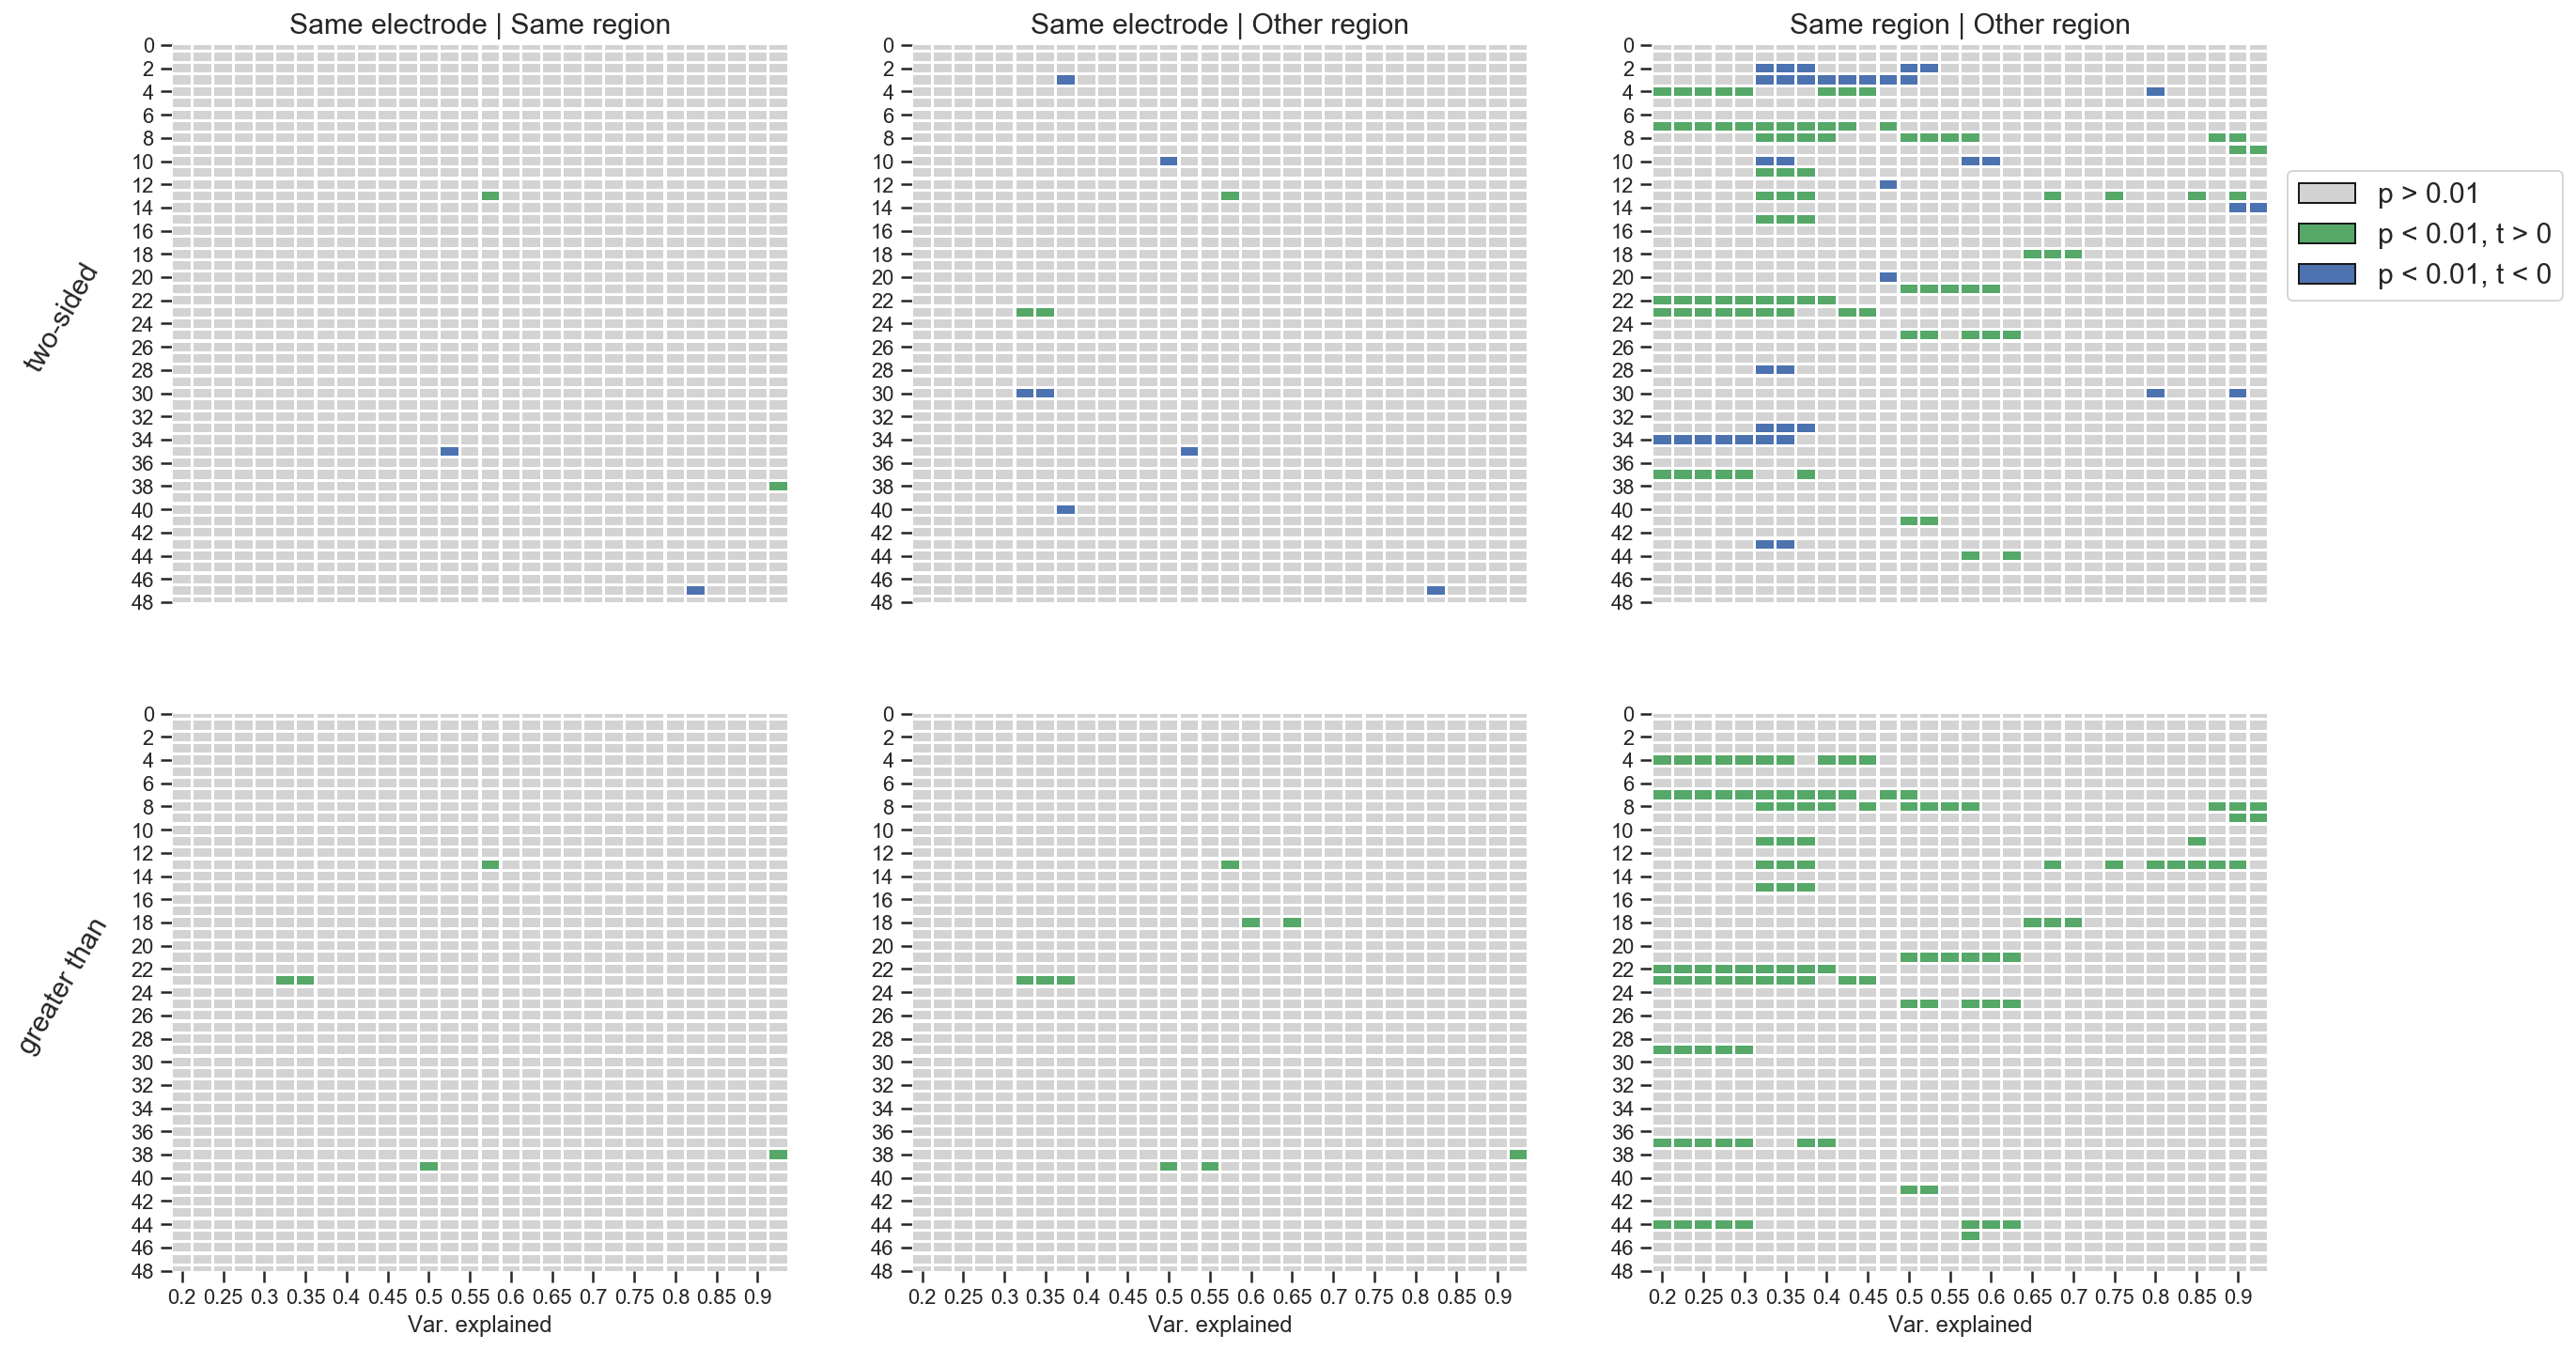

In [15]:
cmap = matplotlib.colors.ListedColormap(['lightgray', 'b', 'g']) # Color for False and True'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

axs[0, 0].set_title('Same electrode | Same region', fontsize=15)
axs[0, 1].set_title('Same electrode | Other region', fontsize=15)
axs[0, 2].set_title('Same region | Other region', fontsize=15)

# Make heatmaps for pvalues two sided tests
sns.heatmap(filter_it(surr_Pvals_ts_SE_SR, surr_Tvals_ts_SE_SR), linewidth=1.1, xticklabels=False, cmap=cmap, cbar=False, ax=axs[0, 0])

sns.heatmap(filter_it(surr_Pvals_ts_SE_OR, surr_Tvals_ts_SE_OR), linewidth=1.1, xticklabels=False, cmap=cmap, cbar=False, ax=axs[0, 1])

sns.heatmap(filter_it(surr_Pvals_ts_SR_OR, surr_Tvals_ts_SR_OR), linewidth=1.1, xticklabels=False, cmap=cmap, cbar=False, ax=axs[0, 2])

# Make heatmaps for pvalues GREATER 
sns.heatmap(filter_it(surr_Pvals_gt_SE_SR, surr_Tvals_gt_SE_SR), linewidth=1.1, cmap=cmap, cbar=False, ax=axs[1, 0])

sns.heatmap(filter_it(surr_Pvals_gt_SE_OR, surr_Tvals_gt_SE_OR), linewidth=1.1, cmap=cmap, cbar=False, ax=axs[1, 1])

sns.heatmap(filter_it(surr_Pvals_gt_SR_OR, surr_Tvals_gt_SR_OR), linewidth=1.1, cmap=cmap, cbar=False, ax=axs[1, 2])

axs[0, 0].set_ylabel('two-sided', rotation=60, labelpad=30, fontsize=15)
axs[1, 0].set_ylabel('greater than', rotation=60, labelpad=30, fontsize=15)

axs[1, 0].set_xticklabels(THRESHOLDS_VARE[::2])
axs[1, 0].set_xlabel('Var. explained') 

axs[1, 1].set_xticklabels(THRESHOLDS_VARE[::2])
axs[1, 1].set_xlabel('Var. explained')  

axs[1, 2].set_xticklabels(THRESHOLDS_VARE[::2])
axs[1, 2].set_xlabel('Var. explained')

legend_elements = [Patch(facecolor='lightgrey', edgecolor='k', label=f'p > {ALPHA}'),
                   Patch(facecolor='g', edgecolor='k', label=f'p < {ALPHA}, t > 0'),
                   Patch(facecolor='b', edgecolor='k', label=f'p < {ALPHA}, t < 0')]
axs[0, 2].legend(handles=legend_elements, prop={'size': 15}, bbox_to_anchor=(1.5, 0.8));

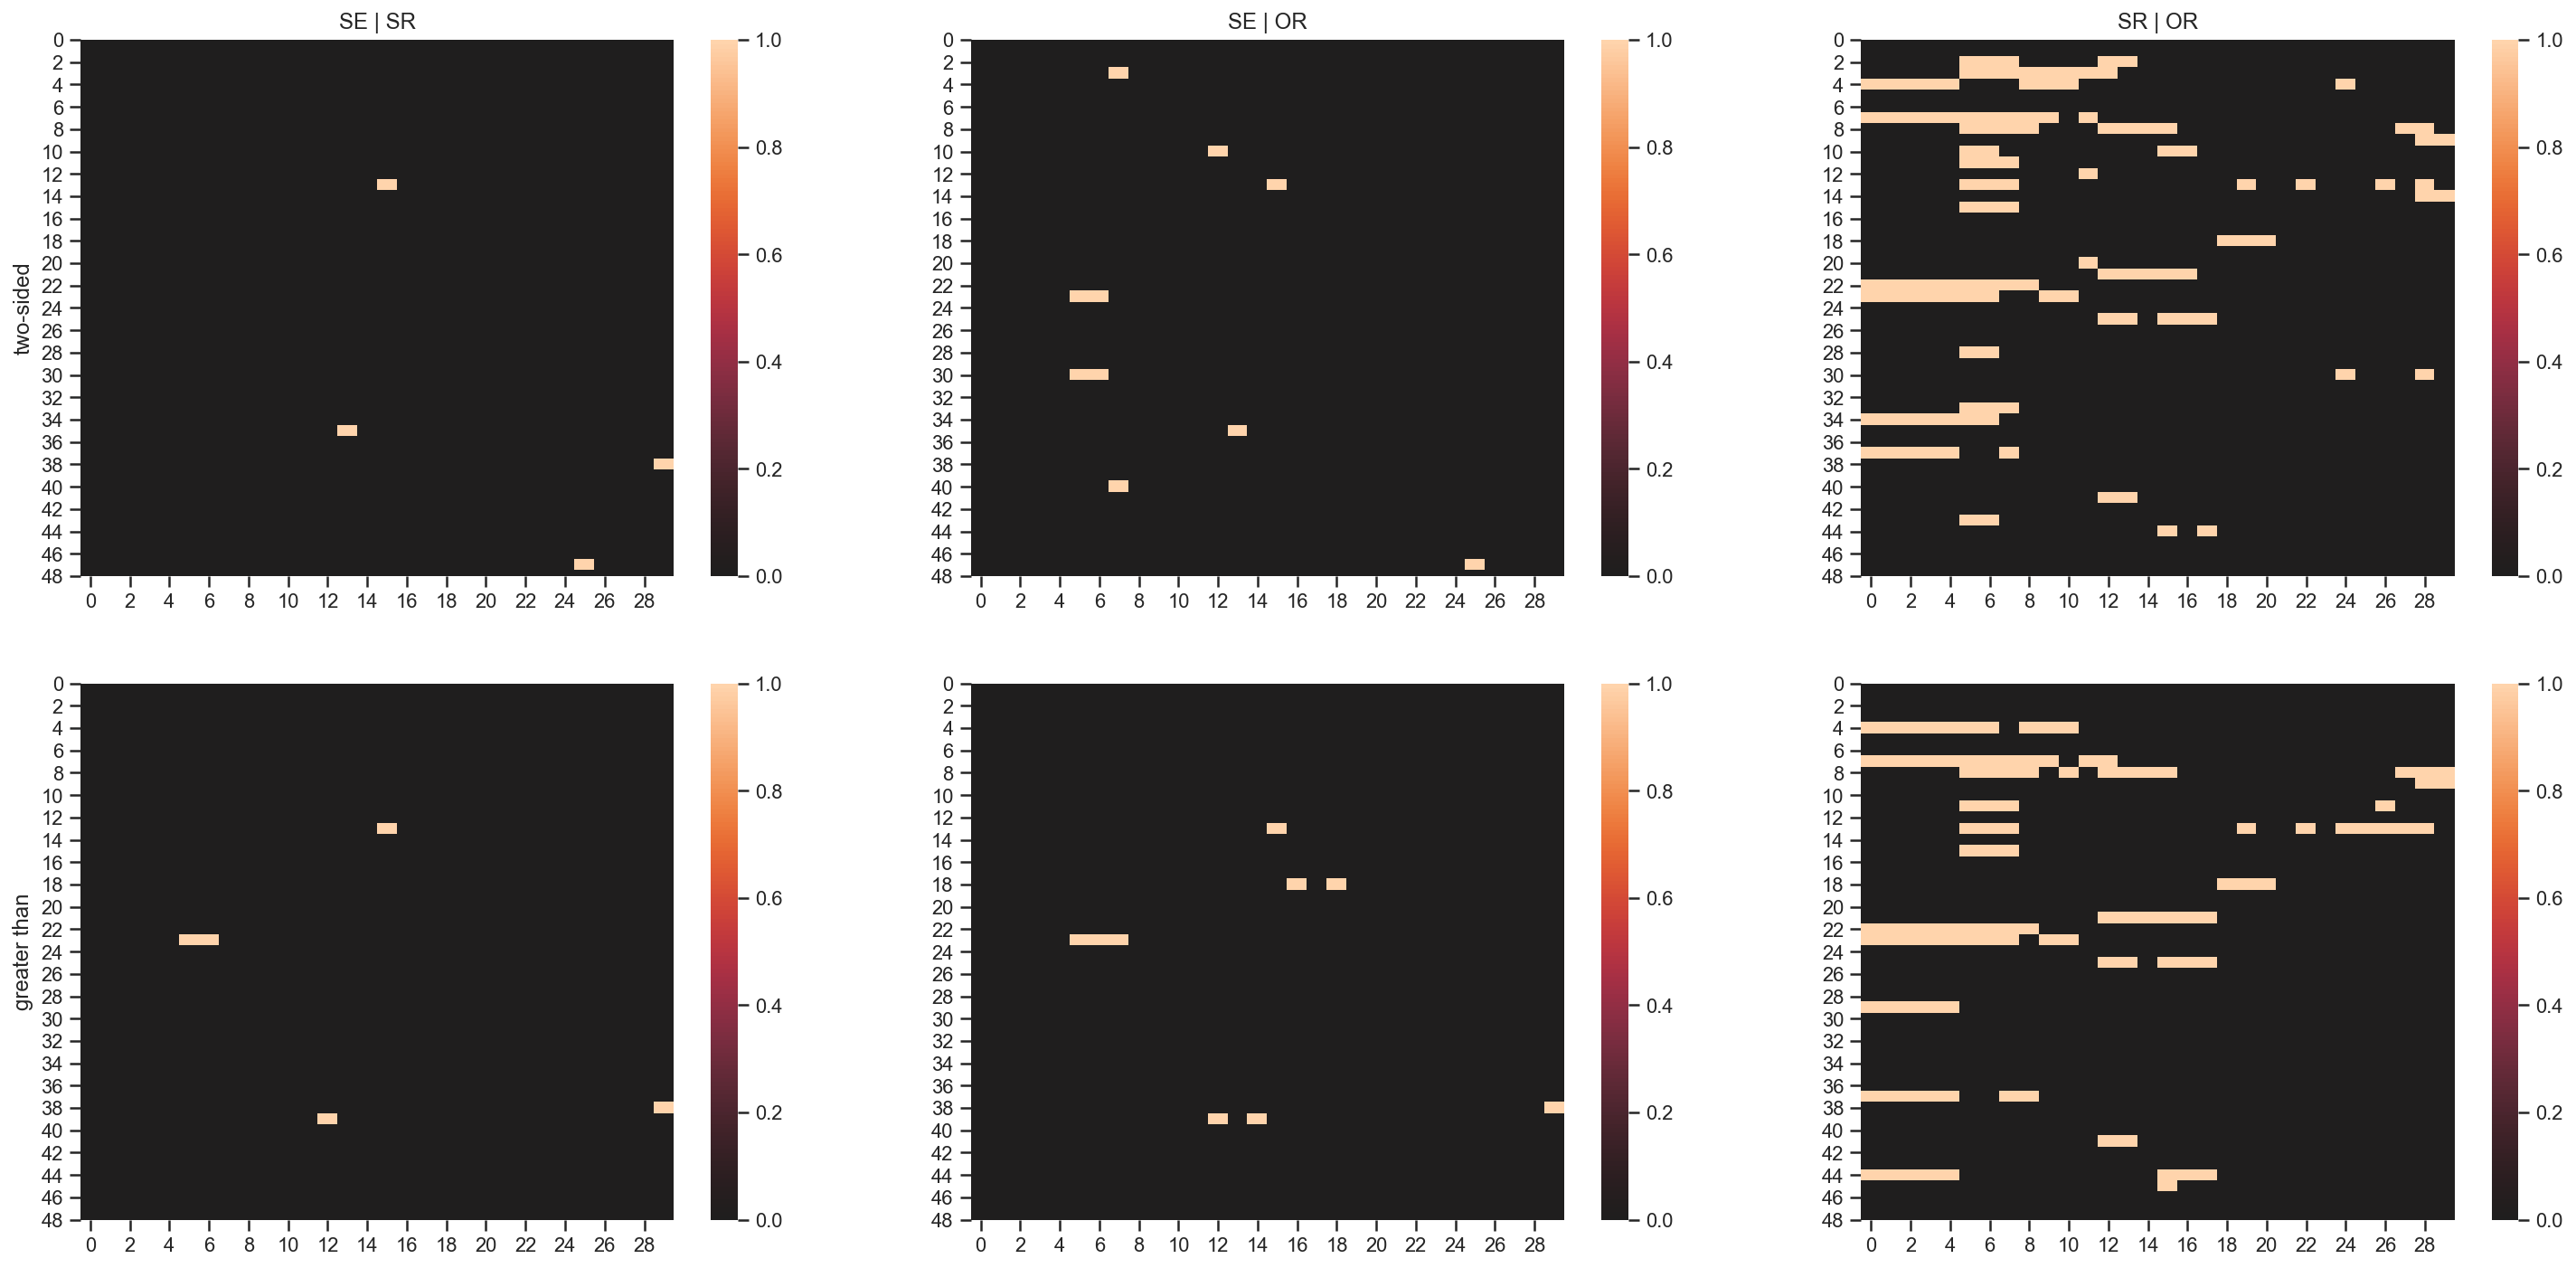

In [111]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 12))

axs[0, 0].set_title('SE | SR')
axs[0, 1].set_title('SE | OR')
axs[0, 2].set_title('SR | OR')

# Make heatmaps for pvalues two sided tests
sns.heatmap(np.array([i[1] for i in surr_twoSided_SE_SR]).reshape(50, 30) < ALPHA, center=0, ax=axs[0, 0])

sns.heatmap(np.array([i[1] for i in surr_twoSided_SE_OR]).reshape(50, 30) < ALPHA, center=0, ax=axs[0, 1])

sns.heatmap(np.array([i[1] for i in surr_twoSided_SR_OR]).reshape(50, 30) < ALPHA, center=0, ax=axs[0, 2])

# Make heatmaps for pvalues GREATER 
sns.heatmap(np.array([i[1] for i in surr_gt_SE_SR]).reshape(50, 30) < ALPHA, center=0, ax=axs[1, 0])

sns.heatmap(np.array([i[1] for i in surr_gt_SE_OR]).reshape(50, 30) < ALPHA, center=0, ax=axs[1, 1])

sns.heatmap(np.array([i[1] for i in surr_gt_SR_OR]).reshape(50, 30) < ALPHA, center=0, ax=axs[1, 2])

axs[0, 0].set_ylabel('two-sided')
axs[1, 0].set_ylabel('greater than');

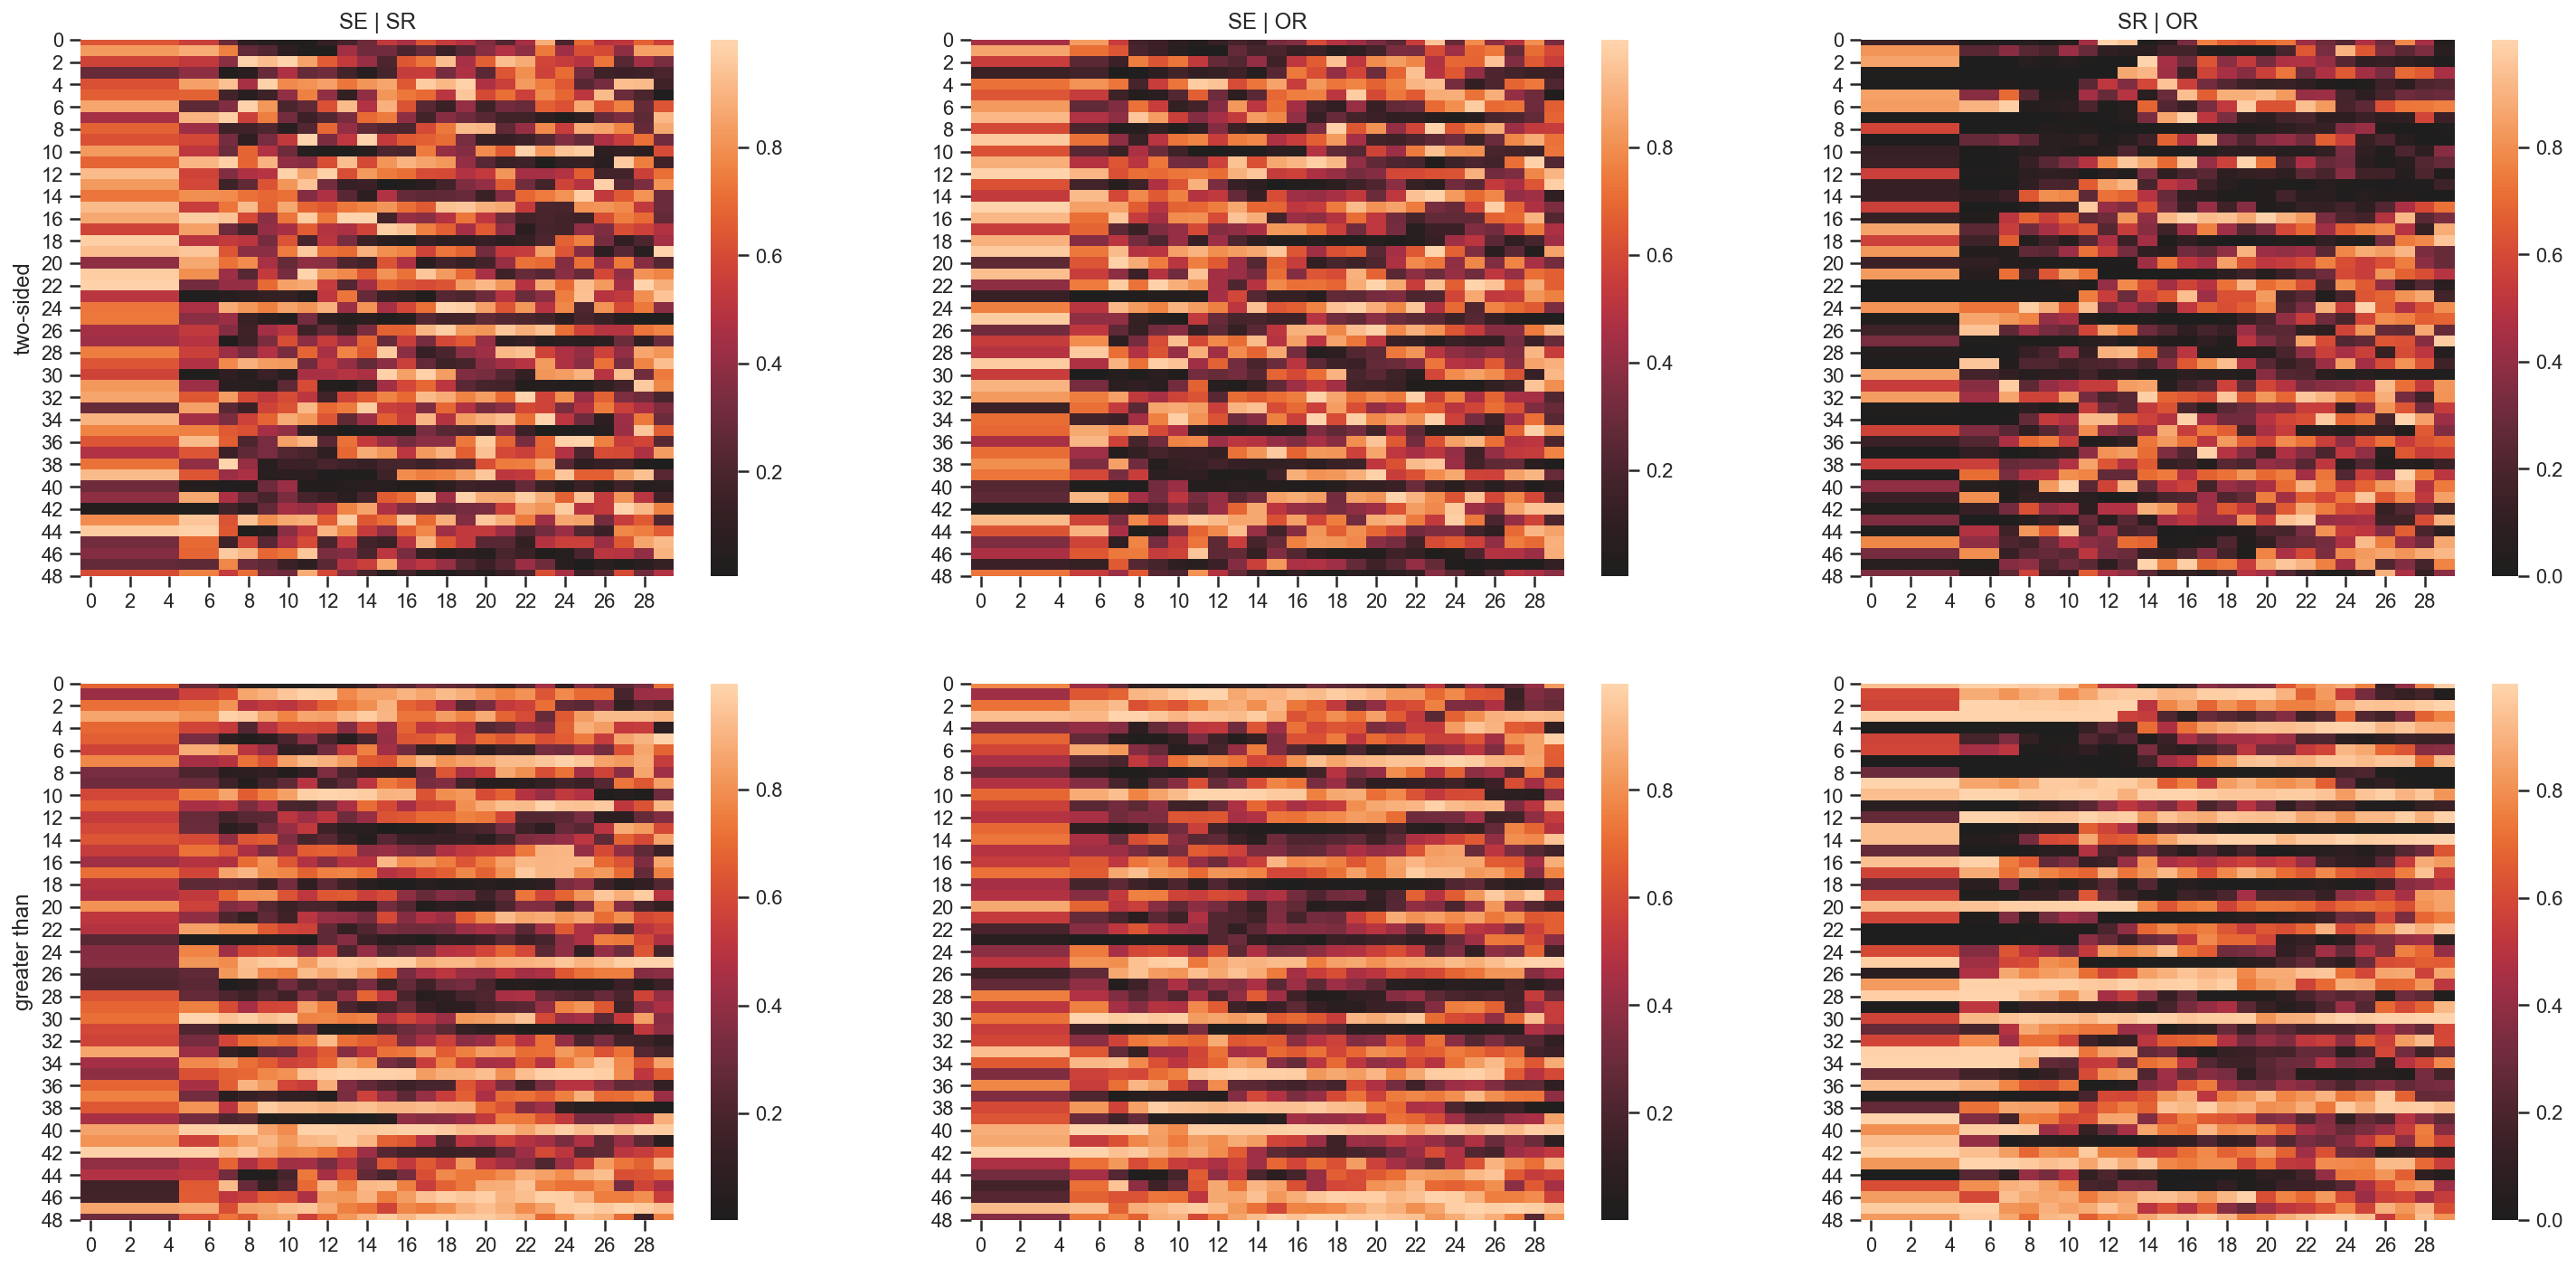

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 12))

axs[0, 0].set_title('SE | SR')
axs[0, 1].set_title('SE | OR')
axs[0, 2].set_title('SR | OR')

# Make heatmaps for pvalues two sided tests
sns.heatmap(np.array([i[1] for i in surr_twoSided_SE_SR]).reshape(50, 30), center=0, ax=axs[0, 0])

sns.heatmap(np.array([i[1] for i in surr_twoSided_SE_OR]).reshape(50, 30), center=0, ax=axs[0, 1])

sns.heatmap(np.array([i[1] for i in surr_twoSided_SR_OR]).reshape(50, 30), center=0, ax=axs[0, 2])

# Make heatmaps for pvalues GREATER 
sns.heatmap(np.array([i[1] for i in surr_gt_SE_SR]).reshape(50, 30), center=0, ax=axs[1, 0])

sns.heatmap(np.array([i[1] for i in surr_gt_SE_OR]).reshape(50, 30), center=0, ax=axs[1, 1])

sns.heatmap(np.array([i[1] for i in surr_gt_SR_OR]).reshape(50, 30), center=0, ax=axs[1, 2])

axs[0, 0].set_ylabel('two-sided')
axs[1, 0].set_ylabel('greater than');